# Learnable activation functions
**Name**: Enikő Palencsár \
**Neptune**: YD11NL \
**Course**: Geometric modelling and applications \
**Description**: Implement simple neural networks with different learnable activation functions, chosen from the approximation and interpolation curves we learnt about in class. Observe their performance, strengths, weaknesses.

In [115]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchinfo import summary
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
import copy

## General function for training loop

In [116]:
def train_model(model, x_train, y_train, optimizer, loss_fn, epochs: int = 1000, info_frequency: int = 50):
    """Training loop for PyTorch model
    
    Arguments: model, training features, expected output features, optimizer, 
    loss function, number of epoch to run, number of epochs on which loss info should be printed.
    Returns list of training loss values per epoch.
    """
    assert(epochs > 0 and info_frequency > 0), "Epoch number and info frequency must be positive."
    losses = []
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(x_train)
        loss = loss_fn(output, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
        # Print loss occasionally
        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    return losses

In [117]:
def train_model_with_validation(
    model, 
    x_train, y_train,
    x_val, y_val,
    optimizer, 
    loss_fn, 
    epochs: int = 1000, 
    info_frequency: int = 50, 
    patience: int = 10
):
    """Training loop for PyTorch model with validation
    
    Arguments: model, training features, expected output features, validation features and expected validation outputs, optimizer, 
    loss function, number of epoch to run, number of epochs on which loss info should be printed, patience (epochs) for early stopping.
    Returns list of training loss values, list of validation loss values per epoch and total execution time.
    """
    assert(epochs > 0 and info_frequency > 0 and patience > 0), "Epoch number, info frequency and patience must be positive."
    
    start_time = time.time()
    train_losses = []
    val_losses = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(x_train)
        loss = loss_fn(output, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        #Validation
        model.eval()
        with torch.no_grad():
            val_output = model(x_val)
            val_loss = loss_fn(val_output, y_val)
            val_losses.append(val_loss.item())
    
        # Print loss occasionally
        if (epoch + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

        #Early stopping check
        if val_loss.item() < best_val_loss - 1e-6:
            best_val_loss = val_loss.item()
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    model.load_state_dict(best_model_wts)
    duration = time.time() - start_time
    print(f"Training completed in {duration:.2f} seconds. Best Val Loss: {best_val_loss:.4f}")
    return train_losses, val_losses, duration

## General function for model evaluation

In [118]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, X_test_tensor, y_test_tensor):
    # Set the model to evaluation mode (disables dropout, batch normalization, etc.)
    model.eval()

    # Disable gradient calculation for inference (saves memory and computation)
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        
        y_pred = y_pred_tensor.numpy()
        y_true = y_test_tensor.numpy()
        
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        # Print metrics
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"R² Score: {r2:.4f}")
        
        # Visualizing the predictions vs actual values
        plt.figure(figsize=(12, 6))

        # Plotting the predictions vs actual values
        plt.subplot(1, 2, 1)
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.plot([0, 1], [0, 1], '--r', label="Perfect Prediction")  # Line for perfect prediction
        plt.title("Predictions vs Actual")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.legend()

        # Visualizing the distribution of predictions
        plt.subplot(1, 2, 2)
        plt.hist(y_pred, bins=30, alpha=0.7, color='blue', label="Predictions")
        plt.hist(y_true, bins=30, alpha=0.7, color='red', label="Actual Values")
        plt.title("Distribution of Predictions vs Actual")
        plt.xlabel("Chance of Admit")
        plt.ylabel("Frequency")
        plt.legend()

        plt.tight_layout()
        plt.show()

    return mae, mse, r2

## General functions for loss and activation function visualization

In [119]:
def visualize_activation(title, activation, x_train, y_train = None):
    with torch.no_grad():
        y = activation(x_train)
    
    plt.figure(figsize=(8, 4))
    
    # Plot the learned activation function
    plt.plot(x_train.numpy(), y.numpy(), label='Learned activation function', color='blue')
    
    # Plot the training data points
    if y_train is not None:
        plt.plot(x_train.numpy(), y_train.numpy(), label='Training data', color='green')
    
    plt.title(title)
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.grid(True)
    plt.legend()
    plt.show()

In [120]:
def visualize_loss(title, losses, val_losses = None ):
    plt.figure(figsize=(12, 5))
    plt.plot(losses, label='Training loss')
    if val_losses:
        plt.plot(val_losses, label='Validation loss')   
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.show()

## Class for a B-spline activation function
* Initialization of trainable parameters (control points)
* Knots uniformly distributed over $[0, 1]$ (could be trainable too, with monotonity condition)
* Forward pass definition
    * Scale inputs to be inside the interval $[u_{k-1}, u_{n+1}]$
    * Calculate the tensor of basis functions for the input as a matrix
    * Multiply each inner matrix with the corresponding knot value
    * Sum the corresponding elements of the resulting matrices, get a matrix with the input's dimensions
    * Be eternally happy

In [121]:
class BSplineActivation(nn.Module):
    def __init__(self, degree: int, control_point_num: int):
        super(BSplineActivation, self).__init__()
        self.degree = degree
        self.control_point_num = control_point_num
        # Randomize control points and make them learnable
        self.control_points = nn.Parameter(torch.randn(control_point_num))
        # Let the knots be uniformly distributed over the interval [0, 1]
        self.knots = torch.linspace(0, 1, control_point_num + degree + 1)

    def forward(self, x):
        # Scale the input into the interval of the knots
        x = self.scale_to_interval(x, self.knots[self.degree], self.knots[-self.degree-1])
        basis = self.basis_functions(x)
        sum_members = basis * self.control_points.view(self.control_point_num, 1, 1)
        result = torch.sum(sum_members, dim=0)
        return result

    def scale_to_interval(self, x, min_val, max_val):
        x_min, x_max = x.min(), x.max()
        x_scaled = min_val + (x - x_min) * (max_val - min_val) / (x_max - x_min)
        return x_scaled

    def basis_functions(self, x):
        k = self.degree
        # Store the i-th k-rank normalized B-spline bases for all elements of x
        basis = torch.zeros((self.control_point_num, x.shape[0], x.shape[1]))
        for i in range(0, self.control_point_num):
            basis[i] = self.basis_function(x, i, k)
        return basis

    def basis_function(self, x, i, k):
        if k == 1:
            return ((self.knots[i] <= x) & (x < self.knots[i+1])).float()
        else:
            coeff1 = (x - self.knots[i])/(self.knots[i+k-1]-self.knots[i])
            coeff2 = (self.knots[i + k] - x)/(self.knots[i+k]-self.knots[i+1])
            return coeff1 * self.basis_function(x, i, k-1) + coeff2 * self.basis_function(x, i+1, k-1)

### A simple test for the activation layer

In [122]:
linear = nn.Linear(1, 2)
activation = BSplineActivation(degree=3, control_point_num=10)
input = torch.linspace(0, 1, 5).unsqueeze(1)
x = linear(input)
x = activation(x)
input.shape, input, x.shape, x

(torch.Size([5, 1]),
 tensor([[0.0000],
         [0.2500],
         [0.5000],
         [0.7500],
         [1.0000]]),
 torch.Size([5, 2]),
 tensor([[-0.4107,  1.7297],
         [-0.5761,  1.1833],
         [-0.4651, -0.2661],
         [-0.1350,  0.5918],
         [ 0.2088,  0.9221]], grad_fn=<SumBackward1>))

## A minimal network with learnable B-spline activation
Practically a simple B-spline approximation problem to be solved using backpropagation.

In [123]:
class BSplineNN(nn.Module):
    def __init__(self, degree, control_point_num):
        super(BSplineNN, self).__init__()
        self.input_layer = nn.Linear(1, 1)
        # self.hidden_layer = nn.Linear(64, 64)
        self.output_layer = nn.Linear(1, 1)
        self.activation = BSplineActivation(degree=degree, control_point_num=control_point_num)
        # Disable weights and biases in linear layers
        self.initialize_weights()
    
    def initialize_weights(self):
        with torch.no_grad():
            # Setting weights to 1 and making them non-trainable
            for layer in [self.input_layer, self.output_layer]:
                layer.weight = nn.Parameter(torch.ones_like(layer.weight), requires_grad=False)
                layer.bias = nn.Parameter(torch.zeros_like(layer.bias), requires_grad=False)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
        return x

## Generation of synthetic training data (sine function)

In [124]:
x_train = torch.linspace(0, 1, 200).unsqueeze(1)
y_train = torch.sin(2 * np.pi * x_train)

## Training

In [125]:
# Initialize model
bspline_model = BSplineNN(degree=3, control_point_num=10)

# Optimizer
optimizer = optim.Adam(bspline_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

losses = train_model(bspline_model, x_train, y_train, optimizer, loss_fn, epochs = 500, info_frequency = 50)

Epoch [50/500], Loss: 0.1936
Epoch [100/500], Loss: 0.0632
Epoch [150/500], Loss: 0.0326
Epoch [200/500], Loss: 0.0215
Epoch [250/500], Loss: 0.0153
Epoch [300/500], Loss: 0.0112
Epoch [350/500], Loss: 0.0083
Epoch [400/500], Loss: 0.0062
Epoch [450/500], Loss: 0.0045
Epoch [500/500], Loss: 0.0033


## Plot loss

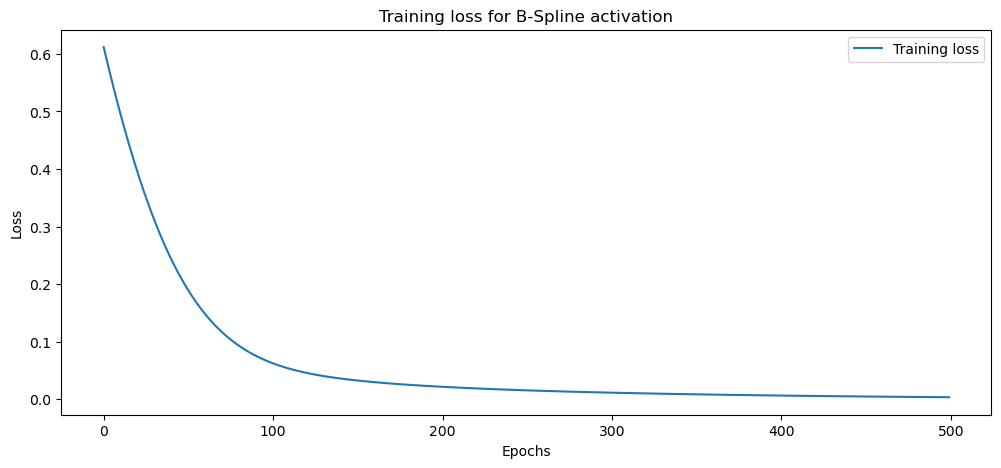

In [126]:
visualize_loss("Training loss for B-Spline activation", losses)

## Visualize the trained activation function
If weights stay on in the linear layers, this constitutes an excellent example of how non-linearities work. The B-spline has the same shape as the original curve, but it's shifted/mirrored. The leftover weights in the linear layers allow it to be transformed linearly without compromising the loss of the network. \
In a network with more neurons, more severe deformations will occur because of the different combinations of weights.

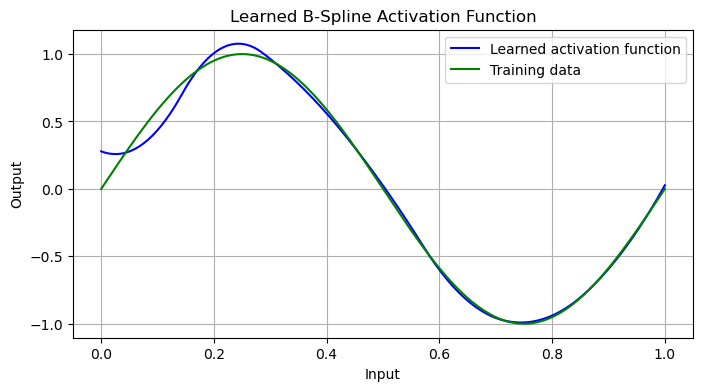

In [127]:
# Visualize Learned Activation
visualize_activation("Learned B-Spline Activation Function", bspline_model.activation, x_train, y_train)

## Inspect model structure

In [128]:
summary(bspline_model, input_size=[1,1])

Layer (type:depth-idx)                   Output Shape              Param #
BSplineNN                                [1, 1]                    --
├─Linear: 1-1                            [1, 1]                    (2)
├─BSplineActivation: 1-2                 [1, 1]                    10
├─Linear: 1-3                            [1, 1]                    (2)
Total params: 14
Trainable params: 10
Non-trainable params: 4
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## Class for NURBS activation function

In [129]:
class NURBSActivation(nn.Module):
    def __init__(self, degree: int, control_point_num: int):
        super(NURBSActivation, self).__init__()
        self.degree = degree
        self.control_point_num = control_point_num
        # Randomize control points and make them learnable
        self.control_points = nn.Parameter(torch.randn(control_point_num))
        self.weights = nn.Parameter(torch.ones(control_point_num))
        # Let the knots be uniformly distributed over the interval [0, 1]
        self.knots = torch.linspace(0, 1, control_point_num + degree + 1)

    def forward(self, x):
        # Scale the input into the interval of the knots
        x = self.scale_to_interval(x, self.knots[self.degree], self.knots[-self.degree-1])
        basis = self.basis_functions(x)
        sum_members = self.weights.view(self.control_point_num, 1, 1) * basis * self.control_points.view(self.control_point_num, 1, 1)
        result = torch.sum(sum_members, dim=0)
        denominator = torch.sum(self.weights.view(self.control_point_num, 1, 1) * basis, dim=0) + 1e-6
        return result / denominator

    def scale_to_interval(self, x, min_val, max_val):
        x_min, x_max = x.min(), x.max()
        x_scaled = min_val + (x - x_min) * (max_val - min_val) / (x_max - x_min)
        return x_scaled

    def basis_functions(self, x):
        k = self.degree
        # Store the i-th k-rank normalized B-spline bases for all elements of x
        basis = torch.zeros((self.control_point_num, x.shape[0], x.shape[1]))
        for i in range(0, self.control_point_num):
            basis[i] = self.basis_function(x, i, k)
        return basis

    def basis_function(self, x, i, k):
        if k == 1:
            return ((self.knots[i] <= x) & (x < self.knots[i+1])).float()
        else:
            coeff1 = (x - self.knots[i])/(self.knots[i+k-1]-self.knots[i])
            coeff2 = (self.knots[i + k] - x)/(self.knots[i+k]-self.knots[i+1])
            return coeff1 * self.basis_function(x, i, k-1) + coeff2 * self.basis_function(x, i+1, k-1)

### Check NURBS activation function
If weights are uniformly 1, forward pass should lead to the same result as BSplineActivation's forward pass given that the control points are the same.

In [130]:
nurbs_activation = NURBSActivation(degree=3, control_point_num=10)
bspline_activation = BSplineActivation(degree=3, control_point_num=10)
nurbs_activation.weights = nn.Parameter(torch.ones(10))
bspline_activation.control_points = nurbs_activation.control_points

input = torch.linspace(0, 1, 5).unsqueeze(1)

x = nurbs_activation(input)
x2 = bspline_activation(input)

input, x, x2

(tensor([[0.0000],
         [0.2500],
         [0.5000],
         [0.7500],
         [1.0000]]),
 tensor([[ 0.7957],
         [-0.6143],
         [-0.1411],
         [-0.7470],
         [-0.6655]], grad_fn=<DivBackward0>),
 tensor([[ 0.7957],
         [-0.6143],
         [-0.1411],
         [-0.7470],
         [-0.6655]], grad_fn=<SumBackward1>))

## A minimal network with learnable NURBS activation

In [131]:
class NURBSNN(nn.Module):
    def __init__(self, degree, control_point_num):
        super(NURBSNN, self).__init__()
        self.input_layer = nn.Linear(1, 1)
        self.output_layer = nn.Linear(1, 1)
        self.activation = NURBSActivation(degree=degree, control_point_num=control_point_num)
        # Disable weights and biases in linear layers
        self.initialize_weights()
        
    def initialize_weights(self):
        with torch.no_grad():
            # Setting weights to 1 and making them non-trainable
            for layer in [self.input_layer, self.output_layer]:
                layer.weight = nn.Parameter(torch.ones_like(layer.weight), requires_grad=False)
                layer.bias = nn.Parameter(torch.zeros_like(layer.bias), requires_grad=False)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
        return x

## Training

In [132]:
# Initialize model
nurbs_model = NURBSNN(degree=3, control_point_num=10)

# Optimizer
optimizer = optim.Adam(nurbs_model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

losses = train_model(nurbs_model, x_train, y_train, optimizer, loss_fn, epochs = 1000, info_frequency = 50)

Epoch [50/1000], Loss: 0.0064
Epoch [100/1000], Loss: 0.0009
Epoch [150/1000], Loss: 0.0002
Epoch [200/1000], Loss: 0.0001
Epoch [250/1000], Loss: 0.0001
Epoch [300/1000], Loss: 0.0001
Epoch [350/1000], Loss: 0.0001
Epoch [400/1000], Loss: 0.0000
Epoch [450/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [550/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [650/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [750/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [850/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Epoch [950/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000


### Loss

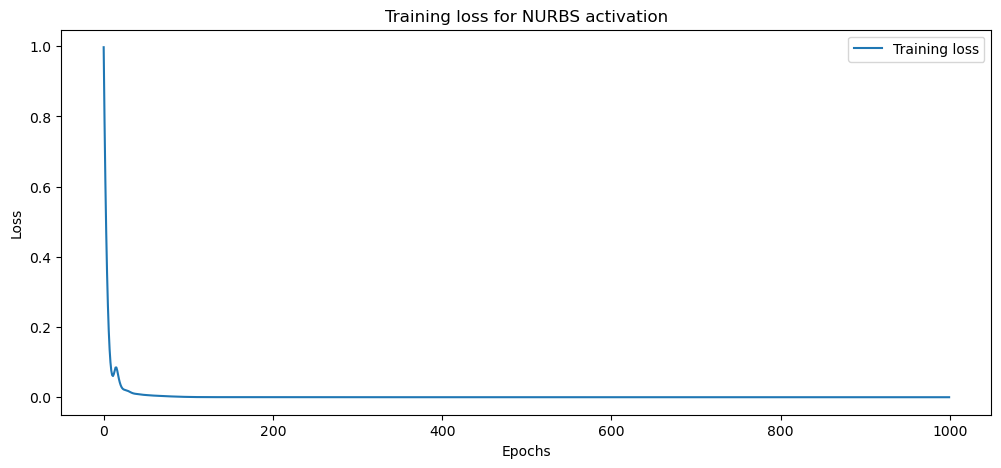

In [133]:
visualize_loss("Training loss for NURBS activation", losses)

### Model structure

In [134]:
summary(nurbs_model, input_size=[1,1])

Layer (type:depth-idx)                   Output Shape              Param #
NURBSNN                                  [1, 1]                    --
├─Linear: 1-1                            [1, 1]                    (2)
├─NURBSActivation: 1-2                   [1, 1]                    20
├─Linear: 1-3                            [1, 1]                    (2)
Total params: 24
Trainable params: 20
Non-trainable params: 4
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Function learned

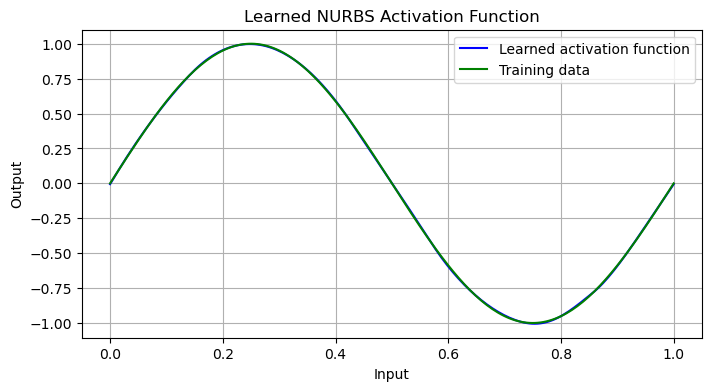

In [135]:
# Visualize Learned Activation
visualize_activation("Learned NURBS Activation Function", nurbs_model.activation, x_train, y_train)

## Class for Lagrange activation function

In [136]:
class LagrangeActivation(nn.Module):
    def __init__(self, degree: int):
        super(LagrangeActivation, self).__init__()
        self.degree = degree
        # Randomize interpolation points (y values) and make them learnable
        self.interpolation_points = nn.Parameter(torch.randn(degree + 1))
        self.u_values = torch.linspace(-1, 1, degree + 1)

    def forward(self, x):
        self.u_values = torch.linspace(x.min(), x.max(), self.degree + 1)
        lagrange = self.lagrangePolynomial(x) / self.lagrangePolynomialDenominator()
        return torch.sum(lagrange * self.interpolation_points, axis=-1)

    def lagrangePolynomialDenominator(self):
        u_i = self.u_values.unsqueeze(0)
        u_j = self.u_values.unsqueeze(1)
        
        # Create nxn self-difference matrix for u_values
        diff = u_i - u_j
        
        # The difference should not be part of the product if i = j (is then 0)
        # So the diagonal should be switched from containing all zeros, to all ones (ones do not affect the product)
        diff.fill_diagonal_(1.0)

        # Return list of Lagrange denominators (products of all self-differences in a row)
        return torch.prod(diff, axis=-1);

    def lagrangePolynomial(self, x):
        # Add 2 dimensions to the last dimension of x
        x_expanded = x.unsqueeze(-1).unsqueeze(-1)

        # u_values is a 1d array, get element count
        n = self.u_values.shape[0]

        # Expand u_values into a nxn matrix such that each row of the mx is u_values
        u_expanded = self.u_values.unsqueeze(0).expand(n, -1)

        # Create a mask using the negated nxn identity matrix
        mask = ~torch.eye(n, dtype=torch.bool, device=self.u_values.device)

        # Delete the main diagonal values from u_expanded, using the mask
        u_expanded = u_expanded[mask].view(n, n - 1)

        # Elements of diff contain an n*n-1 matrix for every x, the elements of the Lagrange polynomial products in the nominator
        diff = x_expanded - u_expanded

        # Return with the products aka inner row sums
        return torch.prod(diff, axis=-1);

### Check activation function shape (should be given degree polynomial)

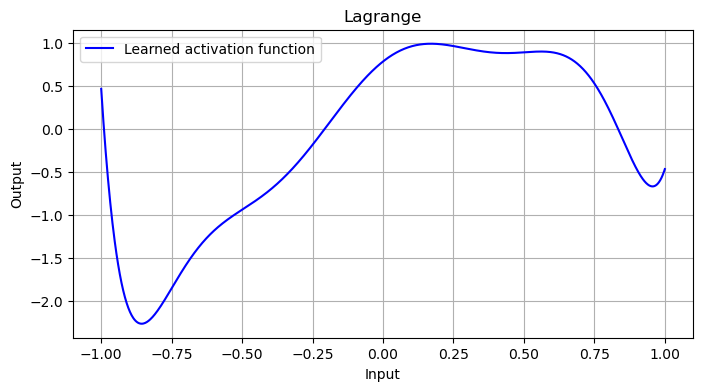

In [137]:
degree = 8
act = LagrangeActivation(degree)
visualize_activation("Lagrange", act, torch.linspace(-1, 1, 1000))

## Minimal network with Lagrange activation

In [138]:
class LagrangeNN(nn.Module):
    def __init__(self, degree):
        super(LagrangeNN, self).__init__()
        self.input_layer = nn.Linear(1, 1)
        self.output_layer = nn.Linear(1, 1)
        self.activation = LagrangeActivation(degree=degree)
        # Disable weights and biases in linear layers
        self.initialize_weights()
        
    def initialize_weights(self):
        with torch.no_grad():
            # Setting weights to 1 and making them non-trainable
            for layer in [self.input_layer, self.output_layer]:
                layer.weight = nn.Parameter(torch.ones_like(layer.weight), requires_grad=False)
                layer.bias = nn.Parameter(torch.zeros_like(layer.bias), requires_grad=False)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
        return x

## Training loop

In [139]:
# Initialize model
lagrange_model = LagrangeNN(degree=3)

# Optimizer
optimizer = optim.Adam(lagrange_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

losses = train_model(lagrange_model, x_train, y_train, optimizer, loss_fn, epochs = 1000, info_frequency = 50)

Epoch [50/1000], Loss: 0.5620
Epoch [100/1000], Loss: 0.2132
Epoch [150/1000], Loss: 0.0856
Epoch [200/1000], Loss: 0.0373
Epoch [250/1000], Loss: 0.0176
Epoch [300/1000], Loss: 0.0095
Epoch [350/1000], Loss: 0.0063
Epoch [400/1000], Loss: 0.0051
Epoch [450/1000], Loss: 0.0047
Epoch [500/1000], Loss: 0.0046
Epoch [550/1000], Loss: 0.0046
Epoch [600/1000], Loss: 0.0046
Epoch [650/1000], Loss: 0.0046
Epoch [700/1000], Loss: 0.0046
Epoch [750/1000], Loss: 0.0046
Epoch [800/1000], Loss: 0.0046
Epoch [850/1000], Loss: 0.0046
Epoch [900/1000], Loss: 0.0046
Epoch [950/1000], Loss: 0.0046
Epoch [1000/1000], Loss: 0.0046


### Plot loss curve

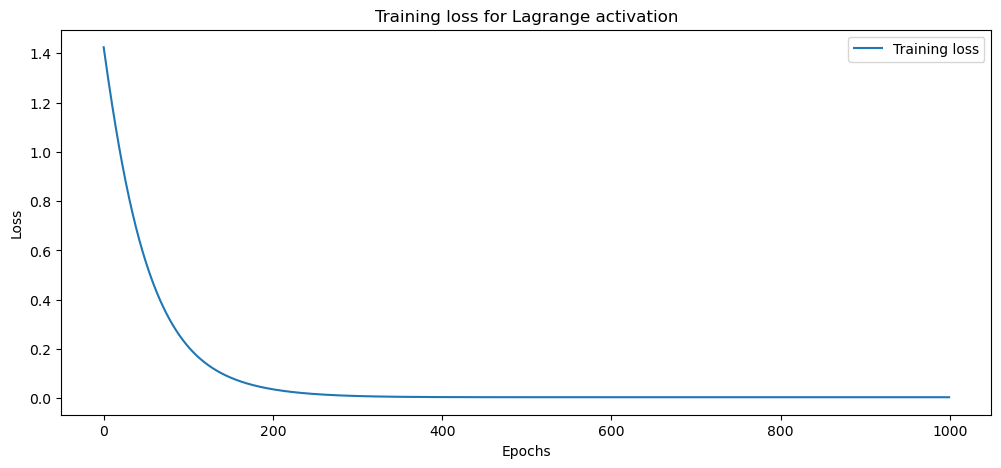

In [140]:
visualize_loss("Training loss for Lagrange activation", losses)

### Visualize learned activation

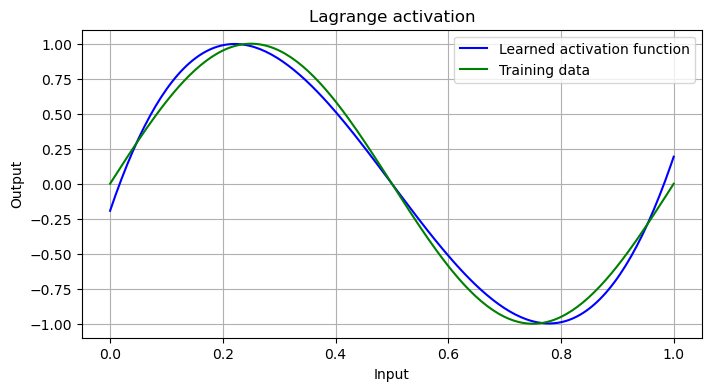

In [141]:
visualize_activation("Lagrange activation", lagrange_model.activation, x_train, y_train)

### View model structure

In [142]:
summary(lagrange_model, input_size=[1,1])

Layer (type:depth-idx)                   Output Shape              Param #
LagrangeNN                               [1, 1]                    --
├─Linear: 1-1                            [1, 1]                    (2)
├─LagrangeActivation: 1-2                [1, 1]                    4
├─Linear: 1-3                            [1, 1]                    (2)
Total params: 8
Trainable params: 4
Non-trainable params: 4
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

# Experiments

## Graduate admissions dataset

In [143]:
df = pd.read_csv('Admission_Predict_Ver1.1.csv')
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


We do not need the serial numbers, drop them.

In [144]:
df_short = df.drop(['Serial No.'], axis=1)

Check for empty values

In [145]:
df_short.isnull().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [146]:
df_short.shape

(500, 8)

### Plot distributions by feature

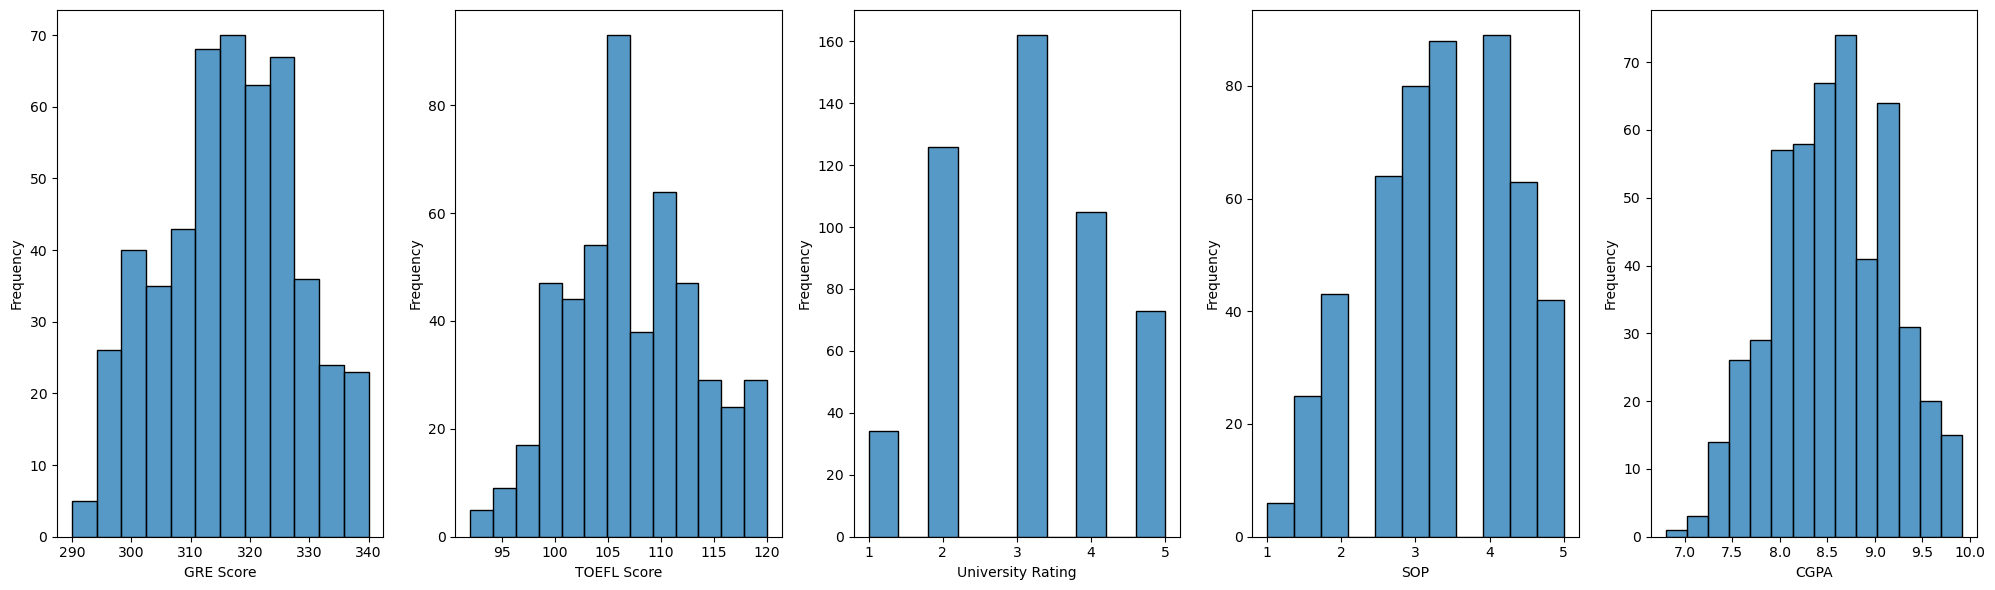

In [147]:
# Define the features to plot
features = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'CGPA']

# Create a figure and axes for the subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

for i, feature in enumerate(features):
    sns.histplot(df_short[feature], ax=axes[i])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Adjust layout for better spacing between plots
plt.tight_layout()
plt.show()

### Prepare data for processing

In [148]:
X = df_short.drop(columns=['Chance of Admit '])
y = df_short['Chance of Admit ']
X.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,337,118,4,4.5,4.5,9.65,1
1,324,107,4,4.0,4.5,8.87,1
2,316,104,3,3.0,3.5,8.00,1
3,322,110,3,3.5,2.5,8.67,1
4,314,103,2,2.0,3.0,8.21,0


In [149]:
y.head()

0    0.92
1    0.76
2    0.72
3    0.80
4    0.65
Name: Chance of Admit , dtype: float64

#### Create train, validation and test sets

In [150]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)
X_train.shape, X_val.shape, X_test.shape

((360, 7), (40, 7), (100, 7))

#### Scale values

In [151]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [152]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

### Construct and train NN with ReLU activation

In [178]:
class ReluNN(nn.Module):
    def __init__(self, input_size):
        super(ReluNN, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        # Result between 0 and 1
        x = self.sigmoid(x)
        return x

In [179]:
input_size = X_train_tensor.shape[1]  # Number of features
relu_model = ReluNN(input_size)

# Optimizer
optimizer = optim.Adam(relu_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

train_losses, val_losses, exec_time = train_model_with_validation(
    relu_model, 
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    optimizer, loss_fn, 
    epochs = 1000, info_frequency = 50, patience = 50)

Epoch [50/1000] - Train Loss: 0.0034 - Val Loss: 0.0025
Epoch [100/1000] - Train Loss: 0.0028 - Val Loss: 0.0023
Epoch [150/1000] - Train Loss: 0.0022 - Val Loss: 0.0023
Early stopping triggered at epoch 178
Training completed in 0.47 seconds. Best Val Loss: 0.0022


### Plot loss curve

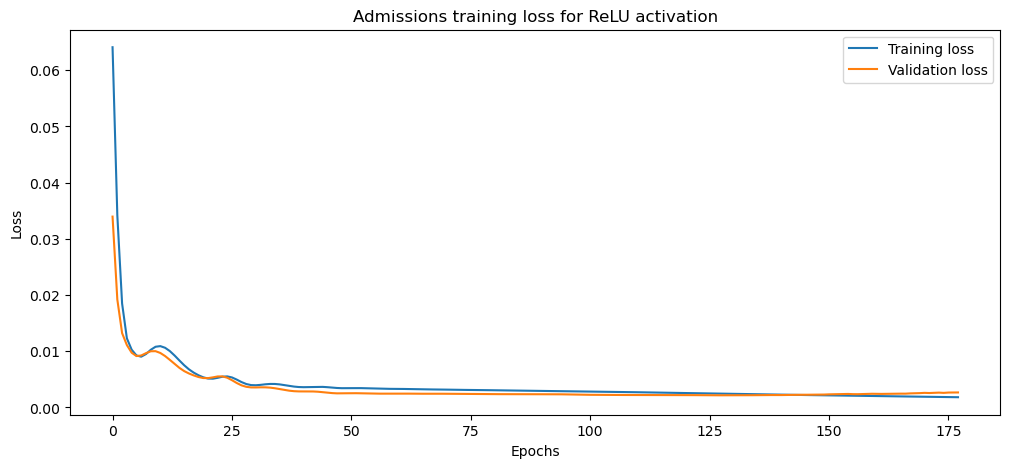

In [180]:
visualize_loss("Admissions training loss for ReLU activation", train_losses, val_losses)

### Evaluate model on test set

Mean Absolute Error (MAE): 0.0430
Mean Squared Error (MSE): 0.0039
R² Score: 0.8073


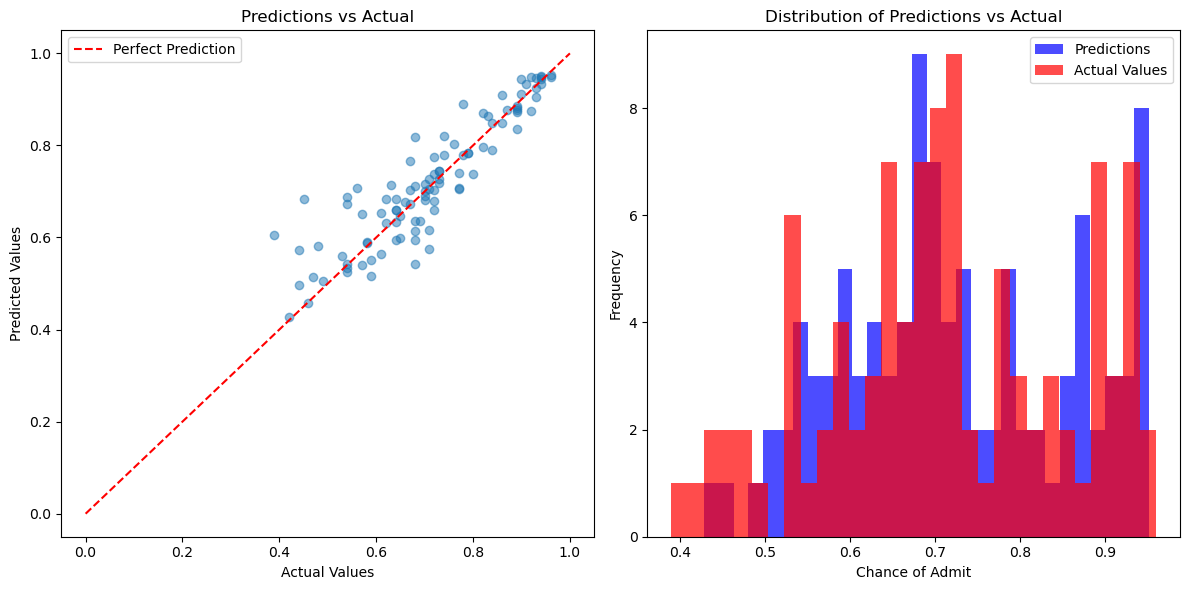

In [181]:
mae, mse, r2 = evaluate_model(relu_model, X_test_tensor, y_test_tensor)

## Make summary dataframe

In [182]:
model_results = pd.DataFrame(columns=[
    'model_type',
    'train_time',
    'test_mse',
    'test_mae',
    'test_r2',
    'epochs'
])

In [183]:
new_row = pd.DataFrame([{
    'model_type': 'ReLU',
    'train_time': exec_time,
    'test_mse': mse,
    'test_mae': mae,
    'test_r2': r2,
    'epochs': len(val_losses)
}])

model_results = pd.concat([model_results, new_row], ignore_index=True)

C:\Users\encip\AppData\Local\Temp\ipykernel_15544\2422367158.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results = pd.concat([model_results, new_row], ignore_index=True)


In [184]:
model_results

,model_type,train_time,test_mse,test_mae,test_r2,epochs
0,ReLU,0.468672,0.00394,0.043041,0.807336,178


## Contruct and train model with B-spline activation

In [185]:
class BsplineNN(nn.Module):
    def __init__(self, input_size, degree, control_point_num):
        super(BsplineNN, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.bspline1 = BSplineActivation(degree = degree, control_point_num = control_point_num)
        self.linear2 = nn.Linear(64, 32)
        self.bspline2 = BSplineActivation(degree = degree, control_point_num = control_point_num)
        self.linear3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.bspline1(x)
        x = self.linear2(x)
        x = self.bspline2(x)
        x = self.linear3(x)
        # To get probability between 0 and 1
        x = self.sigmoid(x)
        return x

In [186]:
input_size = X_train_tensor.shape[1]
bspline_model = BsplineNN(input_size, degree = 3, control_point_num = 10)

# Optimizer
optimizer = optim.Adam(bspline_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

train_losses, val_losses, exec_time = train_model_with_validation(
    bspline_model, 
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    optimizer, loss_fn, 
    epochs = 1000, info_frequency = 50, patience = 50)

Epoch [50/1000] - Train Loss: 0.0035 - Val Loss: 0.0028
Epoch [100/1000] - Train Loss: 0.0028 - Val Loss: 0.0025
Early stopping triggered at epoch 123
Training completed in 5.04 seconds. Best Val Loss: 0.0024


### Loss curve

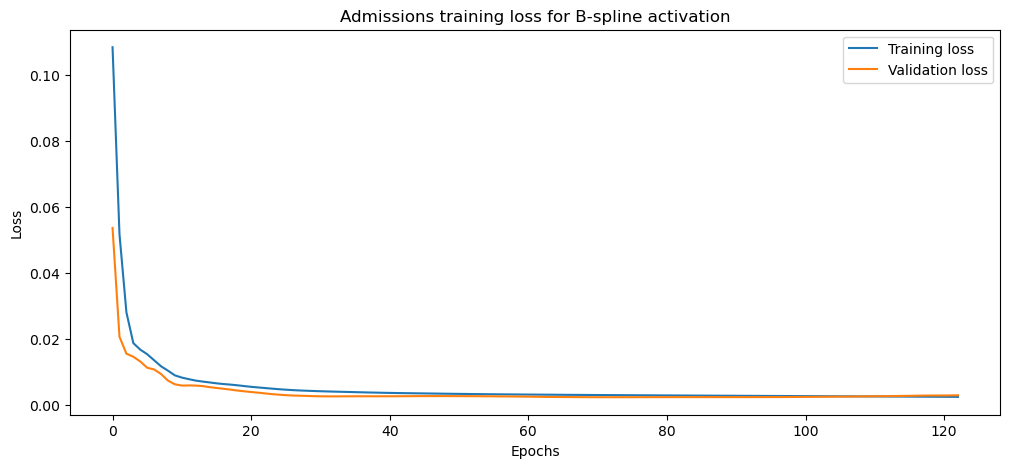

In [187]:
visualize_loss("Admissions training loss for B-spline activation", train_losses, val_losses)

### Evaluate

Mean Absolute Error (MAE): 0.0593
Mean Squared Error (MSE): 0.0059
R² Score: 0.7131


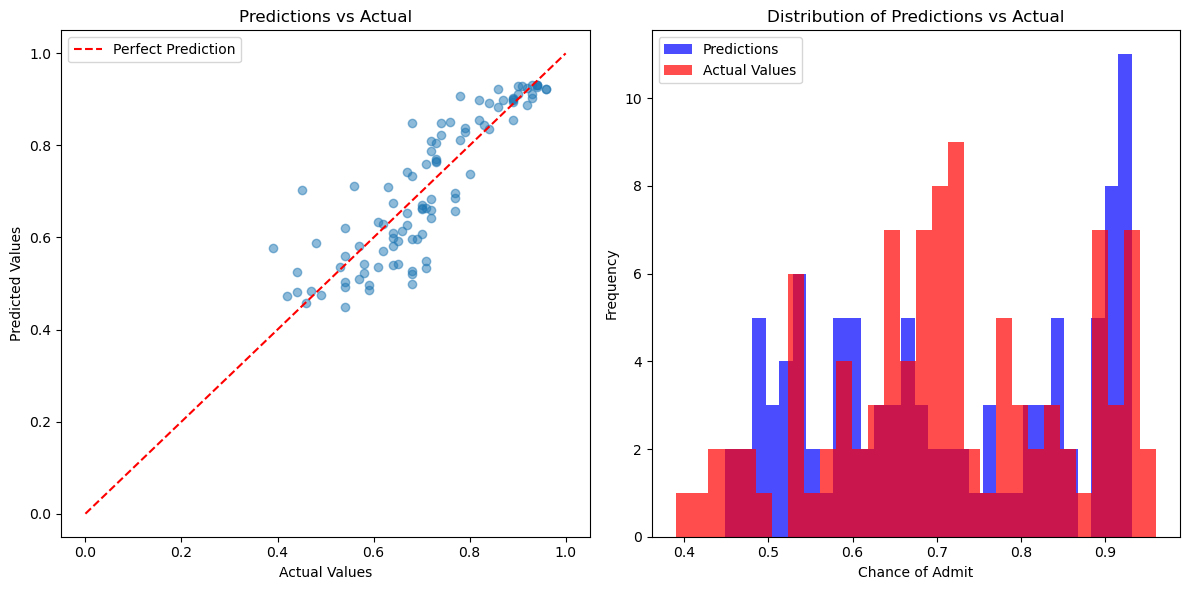

In [188]:
mae, mse, r2 = evaluate_model(bspline_model, X_test_tensor, y_test_tensor)

In [189]:
new_row = pd.DataFrame([{
    'model_type': 'B-spline',
    'train_time': exec_time,
    'test_mse': mse,
    'test_mae': mae,
    'test_r2': r2,
    'epochs': len(val_losses)
}])

model_results = pd.concat([model_results, new_row], ignore_index=True)

In [190]:
model_results

,model_type,train_time,test_mse,test_mae,test_r2,epochs
0,ReLU,0.468672,0.003940,0.043041,0.807336,178
1,B-spline,5.035582,0.005867,0.059301,0.713129,123


## Construct and train model with NURBS activation

In [191]:
class NURBSNN(nn.Module):
    def __init__(self, input_size, degree, control_point_num):
        super(NURBSNN, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.nurbs1 = NURBSActivation(degree = degree, control_point_num = control_point_num)
        self.linear2 = nn.Linear(64, 32)
        self.nurbs2 = NURBSActivation(degree = degree, control_point_num = control_point_num)
        self.linear3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.nurbs1(x)
        x = self.linear2(x)
        x = self.nurbs2(x)
        x = self.linear3(x)
        # To get probability between 0 and 1
        x = self.sigmoid(x)
        return x

In [192]:
input_size = X_train_tensor.shape[1]
nurbs_model = NURBSNN(input_size, degree = 3, control_point_num = 10)

# Optimizer
optimizer = optim.Adam(nurbs_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

train_losses, val_losses, exec_time = train_model_with_validation(
    nurbs_model, 
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    optimizer, loss_fn, 
    epochs = 1000, info_frequency = 50, patience = 50)

Epoch [50/1000] - Train Loss: 0.0035 - Val Loss: 0.0033
Epoch [100/1000] - Train Loss: 0.0027 - Val Loss: 0.0031
Early stopping triggered at epoch 115
Training completed in 4.98 seconds. Best Val Loss: 0.0030


### Visualize loss

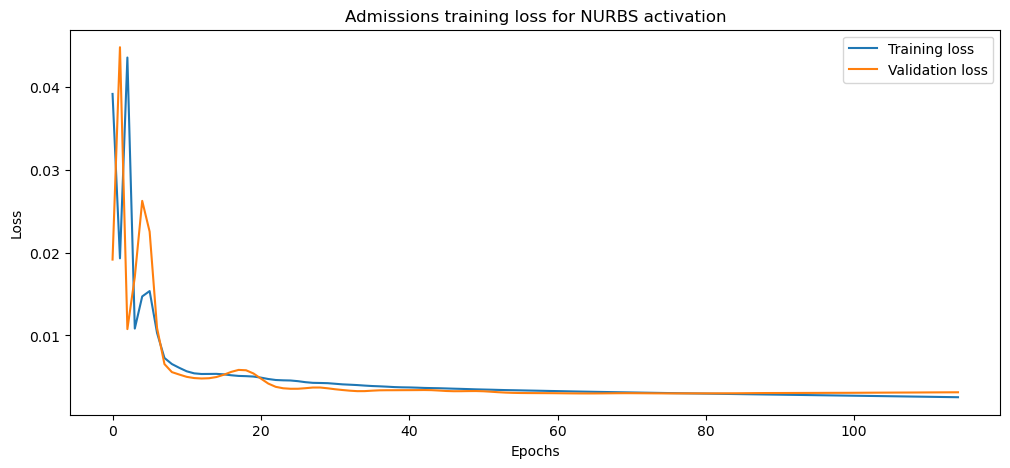

In [193]:
visualize_loss("Admissions training loss for NURBS activation", train_losses, val_losses)

### Evaluate model

Mean Absolute Error (MAE): 0.0472
Mean Squared Error (MSE): 0.0046
R² Score: 0.7733


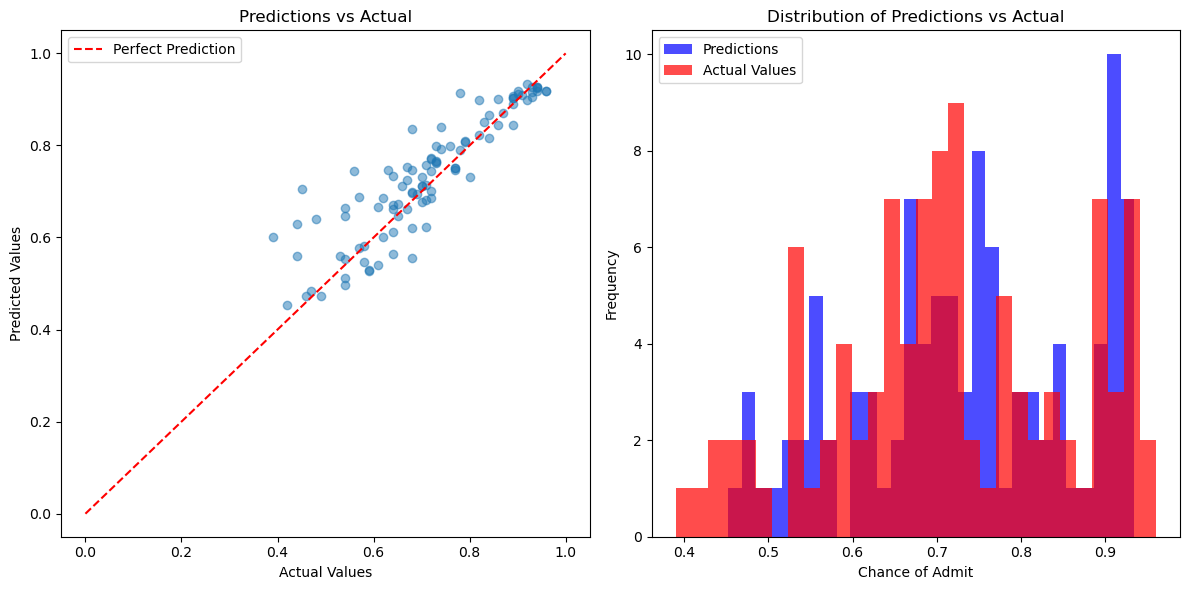

In [194]:
mae, mse, r2 = evaluate_model(nurbs_model, X_test_tensor, y_test_tensor)

In [195]:
new_row = pd.DataFrame([{
    'model_type': 'NURBS',
    'train_time': exec_time,
    'test_mse': mse,
    'test_mae': mae,
    'test_r2': r2,
    'epochs': len(val_losses)
}])

model_results = pd.concat([model_results, new_row], ignore_index=True)

In [196]:
model_results

,model_type,train_time,test_mse,test_mae,test_r2,epochs
0,ReLU,0.468672,0.003940,0.043041,0.807336,178
1,B-spline,5.035582,0.005867,0.059301,0.713129,123
2,NURBS,4.977858,0.004637,0.047176,0.773270,115


## Construct and train model with Lagrange activation

In [197]:
class LagrangeNN(nn.Module):
    def __init__(self, input_size, degree):
        super(LagrangeNN, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.lagrange1 = LagrangeActivation(degree = degree)
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(64, 32)
        self.lagrange2 = LagrangeActivation(degree = degree)
        self.linear3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.lagrange1(x)
        x = self.linear2(x)
        x = self.lagrange2(x)
        x = self.linear3(x)
        # To get probability between 0 and 1
        x = self.sigmoid(x)
        return x

In [198]:
input_size = X_train_tensor.shape[1]
lagrange_model = LagrangeNN(input_size, degree = 13)

# Optimizer
optimizer = optim.Adam(lagrange_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

train_losses, val_losses, exec_time = train_model_with_validation(
    lagrange_model, 
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    optimizer, loss_fn, 
    epochs = 1000, info_frequency = 50, patience = 50)

Epoch [50/1000] - Train Loss: 0.0337 - Val Loss: 0.0248
Epoch [100/1000] - Train Loss: 0.0200 - Val Loss: 0.0369
Epoch [150/1000] - Train Loss: 0.0140 - Val Loss: 0.0818
Early stopping triggered at epoch 156
Training completed in 10.92 seconds. Best Val Loss: 0.0110


### Visualize loss

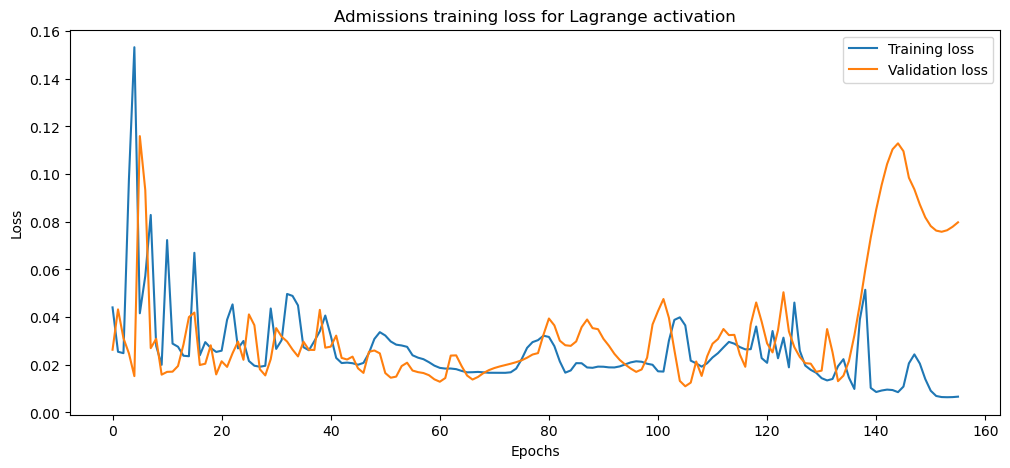

In [199]:
visualize_loss("Admissions training loss for Lagrange activation", train_losses, val_losses)

### Evaluate model

Mean Absolute Error (MAE): 0.1646
Mean Squared Error (MSE): 0.0442
R² Score: -1.1616


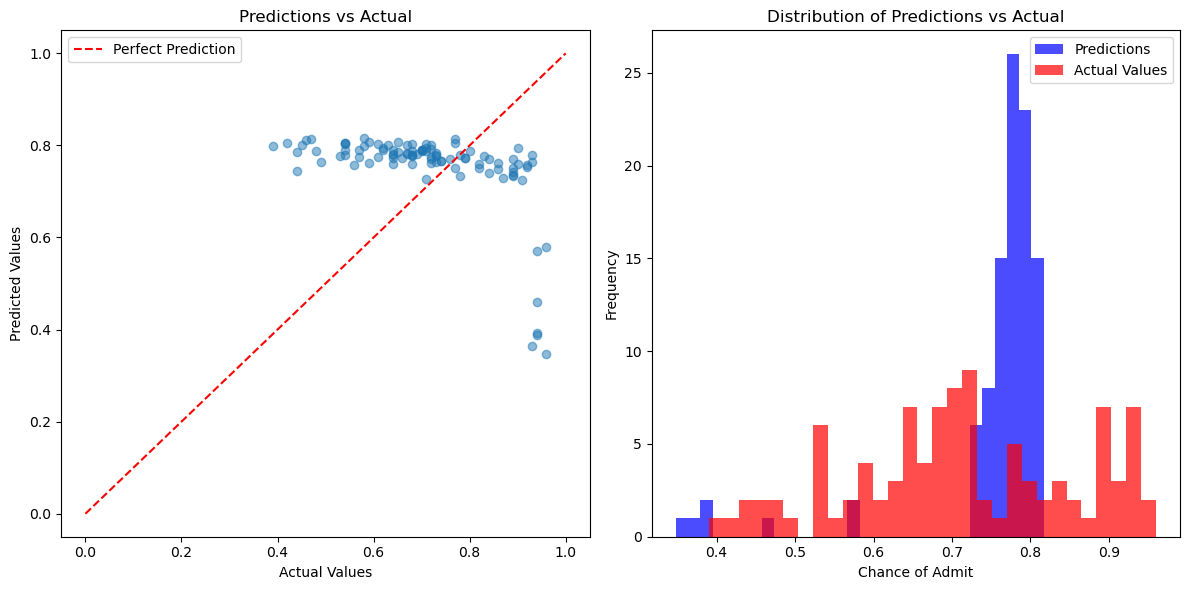

In [200]:
mae, mse, r2 = evaluate_model(lagrange_model, X_test_tensor, y_test_tensor)

In [201]:
new_row = pd.DataFrame([{
    'model_type': 'Lagrange',
    'train_time': exec_time,
    'test_mse': mse,
    'test_mae': mae,
    'test_r2': r2,
    'epochs': len(val_losses)
}])

model_results = pd.concat([model_results, new_row], ignore_index=True)

In [202]:
model_results

,model_type,train_time,test_mse,test_mae,test_r2,epochs
0,ReLU,0.468672,0.003940,0.043041,0.807336,178
1,B-spline,5.035582,0.005867,0.059301,0.713129,123
2,NURBS,4.977858,0.004637,0.047176,0.773270,115
3,Lagrange,10.919130,0.044204,0.164585,-1.161581,156


### <span style="color: green;">Conclusions</span>
- As expected, ReLU activations are by far the fastest (1 order of magnitude lower training times than for learnable activations)
- The usage of B-spline and NURBS activation functions resulted in very similar training times, training epoch numbers and test losses.
- Lagrange activation functions produced the most unfavourable results: 4 times higher losses and 2 times higher training times.
- The test MSE and MAE achieved is very similar for ReLU, B-spline and NURBS activations.
- When using B-spline or NURBS activations, less epochs were needed to produce the same results.
  - This suggests that the optimisation of these learnable activation layers might be advantageous even if we cannot reach the fast performance of a parameterless ReLU function. Less epochs means less backpropagation, which can prove to be a true benefit of these approximation curbe-based learnable activation functions.
- As evidenced by the loss diagrams, B-spline and NURBS activation functions - after a certain number of epochs - provide standard train and validation loss convergence. 
- When using Lagrange activation functions, the oscillation of train and validation losses becomes worryingly high, backpropagation seems to completely stop working, no clear convergence can be observed. This may be due to the the implementation of the related Lagrange coefficient calculations that make gradient estimations malfunction. (?)
- It is important to note that in the calculations above, **linear layer weights** were preserved and set to learnable not only in the case of ReLU but also when using learnable activation functions
  - In theory, the learnable curves could absorb the effect of weights, but maybe not in this NN configuration, as the elimination of weighted sums makes every input edge have the same "importance" in the curve calculations that follow.
  - For a network architecture that allows for the complete elimination of edge weights, see Kolmogorov-Arnold Networks

## Investigate the role of linear layer weights in NURBS NN

In [203]:
edge_weight_summary = pd.DataFrame(columns=[
    'model_type',
    'train_time',
    'test_mse',
    'test_mae',
    'test_r2',
    'epochs'
])

### NURBS network with weights on edges of about 350 parameters

In [204]:
class TinyNURBSNN(nn.Module):
    def __init__(self, input_size, degree, control_point_num):
        super(TinyNURBSNN, self).__init__()
        self.linear1 = nn.Linear(input_size, 16)
        self.nurbs1 = NURBSActivation(degree = degree, control_point_num = control_point_num)
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(16, 8)
        self.nurbs2 = NURBSActivation(degree = degree, control_point_num = control_point_num)
        self.linear3 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.nurbs1(x)
        x = self.linear2(x)
        x = self.nurbs2(x)
        x = self.linear3(x)
        # To get probability between 0 and 1
        x = self.sigmoid(x)
        return x

In [205]:
input_size = X_train_tensor.shape[1]
tiny_nurbs_model = TinyNURBSNN(input_size, degree = 3, control_point_num = 25)

# Optimizer
optimizer = optim.Adam(tiny_nurbs_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

train_losses, val_losses, exec_time = train_model_with_validation(
    tiny_nurbs_model, 
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    optimizer, loss_fn, 
    epochs = 1000, info_frequency = 50, patience = 50)

Epoch [50/1000] - Train Loss: 0.0046 - Val Loss: 0.0161
Epoch [100/1000] - Train Loss: 0.0021 - Val Loss: 0.0141
Epoch [150/1000] - Train Loss: 0.0009 - Val Loss: 0.0247
Early stopping triggered at epoch 153
Training completed in 10.15 seconds. Best Val Loss: 0.0129


### Visualize loss
Minimal oscillation in train loss, bit more in validation loss

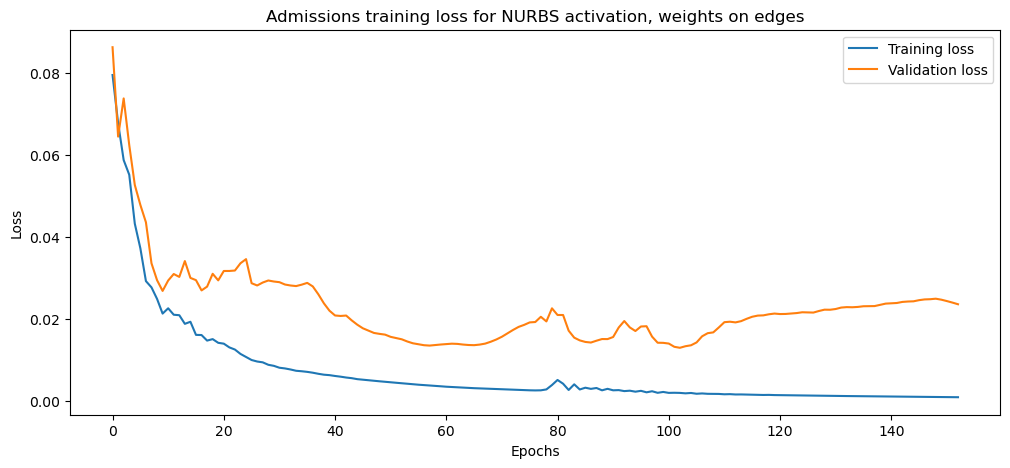

In [206]:
visualize_loss("Admissions training loss for NURBS activation, weights on edges", train_losses, val_losses)

### Evaluate on test set

Mean Absolute Error (MAE): 0.1274
Mean Squared Error (MSE): 0.0239
R² Score: -0.1669


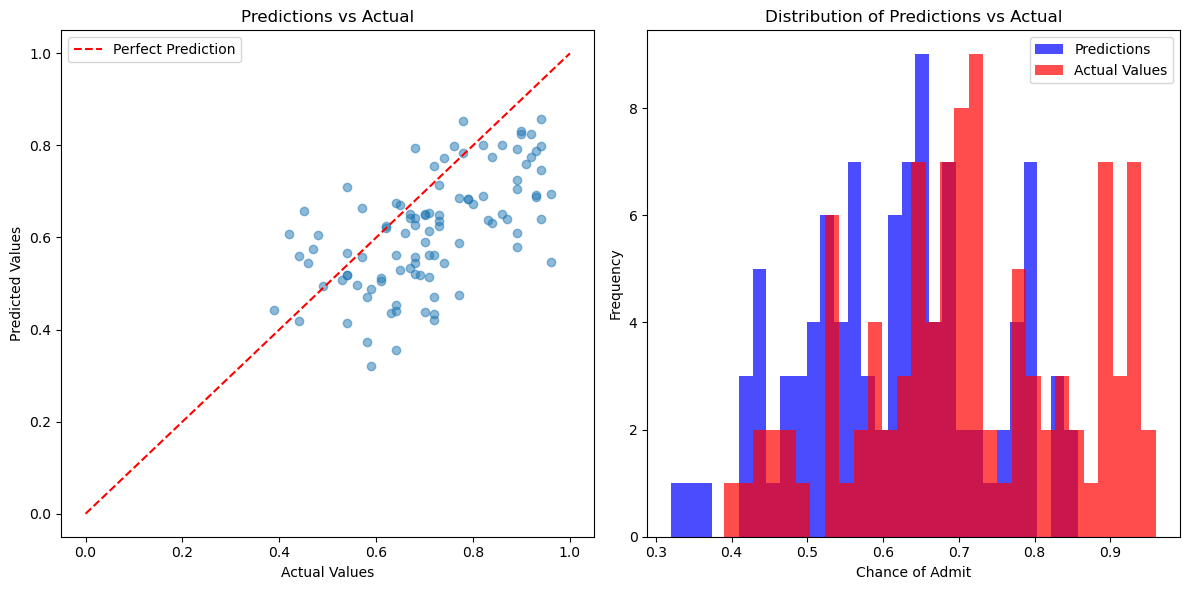

In [207]:
mae, mse, r2 = evaluate_model(tiny_nurbs_model, X_test_tensor, y_test_tensor)

In [208]:
new_row = pd.DataFrame([{
    'model_type': 'NURBS + edge weights',
    'train_time': exec_time,
    'test_mse': mse,
    'test_mae': mae,
    'test_r2': r2,
    'epochs': len(val_losses)
}])

edge_weight_summary = pd.concat([edge_weight_summary, new_row], ignore_index=True)

C:\Users\encip\AppData\Local\Temp\ipykernel_15544\1482124535.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edge_weight_summary = pd.concat([edge_weight_summary, new_row], ignore_index=True)


In [209]:
edge_weight_summary

,model_type,train_time,test_mse,test_mae,test_r2,epochs
0,NURBS + edge weights,10.150926,0.023864,0.12738,-0.166949,153


### Summarize parameter numbers

In [217]:
summary(tiny_nurbs_model, input_size=X_train_tensor.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TinyNURBSNN                              [360, 1]                  --
├─Linear: 1-1                            [360, 16]                 128
├─NURBSActivation: 1-2                   [360, 16]                 50
├─Linear: 1-3                            [360, 8]                  136
├─NURBSActivation: 1-4                   [360, 8]                  50
├─Linear: 1-5                            [360, 1]                  9
├─Sigmoid: 1-6                           [360, 1]                  --
Total params: 373
Trainable params: 373
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.31
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 0.00
Estimated Total Size (MB): 0.15

### NURBS network of about 350 trainable parameters without edge weights in linear layers
Scale by adding more layers, therefore more NURBS activation function calls

In [218]:
class StrippedTinyNURBSNN(nn.Module):
    def __init__(self, input_size, degree, control_point_num):
        super(StrippedTinyNURBSNN, self).__init__()
        self.linear1 = nn.Linear(input_size, 16)
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 8)
        self.linear4 = nn.Linear(8, 1)
        self.nurbs1 = NURBSActivation(degree=degree, control_point_num=control_point_num)
        self.nurbs2 = NURBSActivation(degree=degree, control_point_num=control_point_num)
        self.nurbs3 = NURBSActivation(degree=degree, control_point_num=control_point_num)
        self.nurbs4 = NURBSActivation(degree=degree, control_point_num=control_point_num)
        self.nurbs5 = NURBSActivation(degree=degree, control_point_num=control_point_num)
        self.nurbs6 = NURBSActivation(degree=degree, control_point_num=control_point_num)
        self.nurbs7 = NURBSActivation(degree=degree, control_point_num=control_point_num)
        self.sigmoid = nn.Sigmoid()
        self.initialize_weights()

    def initialize_weights(self):
        with torch.no_grad():
            for layer in [self.linear1, self.linear2, self.linear3, self.linear4]:
                layer.weight = nn.Parameter(torch.ones_like(layer.weight), requires_grad=False)
                layer.bias = nn.Parameter(torch.zeros_like(layer.bias), requires_grad=False)

    def forward(self, x):
        x = self.linear1(x)
        x = self.nurbs1(x)
        x = self.linear2(x)
        x = self.nurbs2(x)
        x = self.linear2(x)
        x = self.nurbs3(x)
        x = self.linear2(x)
        x = self.nurbs4(x)
        x = self.linear2(x)
        x = self.nurbs5(x)
        x = self.linear2(x)
        x = self.nurbs6(x)
        x = self.linear3(x)
        x = self.nurbs7(x)
        x = self.linear4(x)
        x = self.sigmoid(x)
        return x

In [219]:
input_size = X_train_tensor.shape[1]
stripped_nurbs_model = StrippedTinyNURBSNN(input_size, degree = 3, control_point_num = 25)

In [220]:
# Optimizer
optimizer = optim.Adam(stripped_nurbs_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

train_losses, val_losses, exec_time = train_model_with_validation(
    stripped_nurbs_model, 
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    optimizer, loss_fn, 
    epochs = 1000, info_frequency = 50, patience = 50)

Epoch [50/1000] - Train Loss: 0.1160 - Val Loss: 0.1947
Epoch [100/1000] - Train Loss: 0.0599 - Val Loss: 0.0603
Epoch [150/1000] - Train Loss: 0.0352 - Val Loss: 0.0217
Epoch [200/1000] - Train Loss: 0.0284 - Val Loss: 0.0307
Early stopping triggered at epoch 230
Training completed in 50.25 seconds. Best Val Loss: 0.0167


### Visualize loss
High oscillation can be observed both in train and validation loss

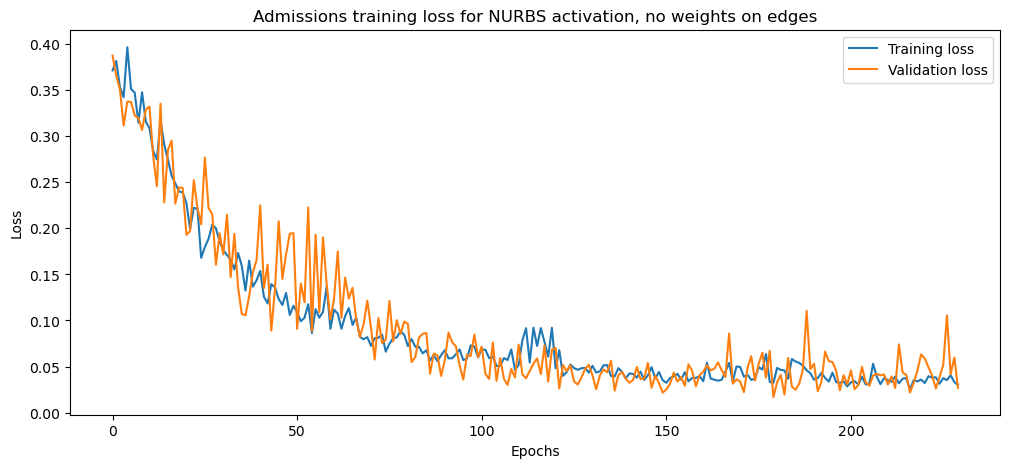

In [221]:
visualize_loss("Admissions training loss for NURBS activation, no weights on edges", train_losses, val_losses)

### Evaluate model

Mean Absolute Error (MAE): 0.1376
Mean Squared Error (MSE): 0.0330
R² Score: -0.6122


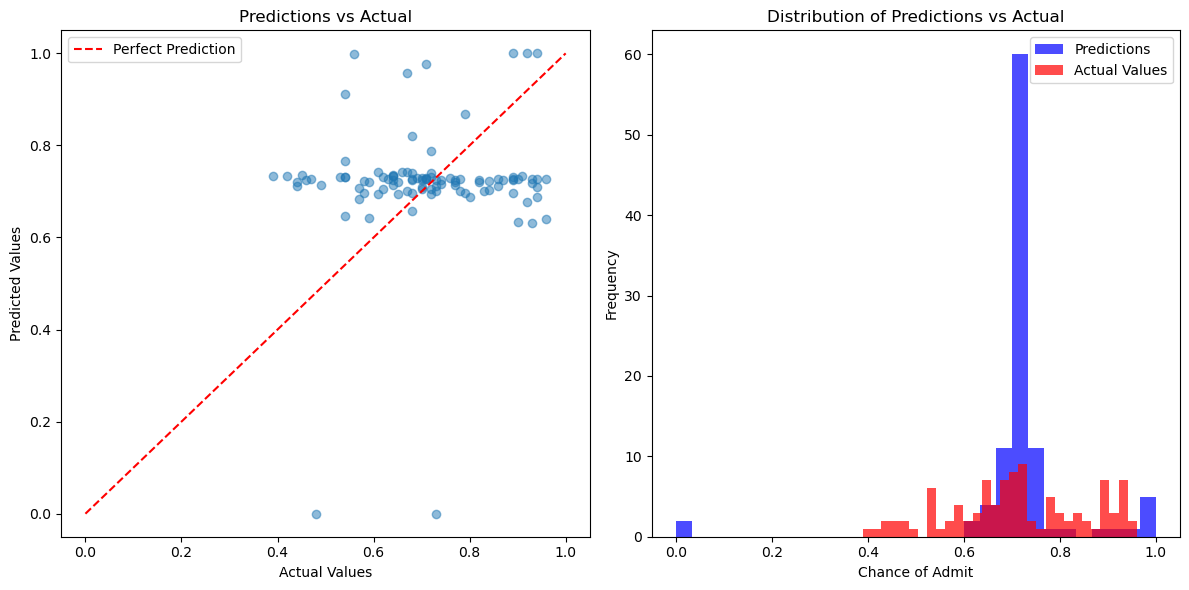

In [222]:
mae, mse, r2 = evaluate_model(stripped_nurbs_model, X_test_tensor, y_test_tensor)

In [223]:
new_row = pd.DataFrame([{
    'model_type': 'NURBS - edge weights',
    'train_time': exec_time,
    'test_mse': mse,
    'test_mae': mae,
    'test_r2': r2,
    'epochs': len(val_losses)
}])

edge_weight_summary = pd.concat([edge_weight_summary, new_row], ignore_index=True)

In [224]:
edge_weight_summary

,model_type,train_time,test_mse,test_mae,test_r2,epochs
0,NURBS + edge weights,10.150926,0.023864,0.127380,-0.166949,153
1,NURBS - edge weights,50.252618,0.032970,0.137552,-0.612228,230


### Summarize parameter numbers

In [226]:
summary(stripped_nurbs_model, input_size=X_train_tensor.shape)

Layer (type:depth-idx)                   Output Shape              Param #
StrippedTinyNURBSNN                      [360, 1]                  --
├─Linear: 1-1                            [360, 16]                 (128)
├─NURBSActivation: 1-2                   [360, 16]                 50
├─Linear: 1-3                            [360, 16]                 (272)
├─NURBSActivation: 1-4                   [360, 16]                 50
├─Linear: 1-5                            [360, 16]                 (recursive)
├─NURBSActivation: 1-6                   [360, 16]                 50
├─Linear: 1-7                            [360, 16]                 (recursive)
├─NURBSActivation: 1-8                   [360, 16]                 50
├─Linear: 1-9                            [360, 16]                 (recursive)
├─NURBSActivation: 1-10                  [360, 16]                 50
├─Linear: 1-11                           [360, 16]                 (recursive)
├─NURBSActivation: 1-12                  [3

### NURBS network of about 350 trainable parameters without edge weights in linear layers
Scale by adding more detail to the existing activation functions (increase control_point_num)

In [227]:
class StrippedTinyNURBSNN2(nn.Module):
    def __init__(self, input_size, degree, control_point_num):
        super(StrippedTinyNURBSNN2, self).__init__()
        self.linear1 = nn.Linear(input_size, 16)
        self.nurbs1 = NURBSActivation(degree = degree, control_point_num = control_point_num)
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(16, 8)
        self.nurbs2 = NURBSActivation(degree = degree, control_point_num = control_point_num)
        self.linear3 = nn.Linear(8, 1)
        self.initialize_weights()

    def initialize_weights(self):
        with torch.no_grad():
            for layer in [self.linear1, self.linear2, self.linear3]:
                layer.weight = nn.Parameter(torch.ones_like(layer.weight), requires_grad=False)
                layer.bias = nn.Parameter(torch.zeros_like(layer.bias), requires_grad=False)

    def forward(self, x):
        x = self.linear1(x)
        x = self.nurbs1(x)
        x = self.linear2(x)
        x = self.nurbs2(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x

In [233]:
input_size = X_train_tensor.shape[1]
stripped_nurbs_model2 = StrippedTinyNURBSNN2(input_size, degree = 3, control_point_num = 90)

In [235]:
# Optimizer
optimizer = optim.Adam(stripped_nurbs_model2.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

train_losses, val_losses, exec_time = train_model_with_validation(
    stripped_nurbs_model2, 
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    optimizer, loss_fn, 
    epochs = 1000, info_frequency = 50, patience = 50)

Epoch [50/1000] - Train Loss: 0.0460 - Val Loss: 0.1736
Epoch [100/1000] - Train Loss: 0.0276 - Val Loss: 0.1373
Epoch [150/1000] - Train Loss: 0.0217 - Val Loss: 0.1291
Epoch [200/1000] - Train Loss: 0.0189 - Val Loss: 0.1182
Epoch [250/1000] - Train Loss: 0.0173 - Val Loss: 0.1082
Epoch [300/1000] - Train Loss: 0.0150 - Val Loss: 0.0908
Epoch [350/1000] - Train Loss: 0.0128 - Val Loss: 0.0805
Epoch [400/1000] - Train Loss: 0.0121 - Val Loss: 0.0802
Epoch [450/1000] - Train Loss: 0.0121 - Val Loss: 0.0703
Epoch [500/1000] - Train Loss: 0.0115 - Val Loss: 0.0644
Epoch [550/1000] - Train Loss: 0.0112 - Val Loss: 0.0631
Epoch [600/1000] - Train Loss: 0.0111 - Val Loss: 0.0631
Early stopping triggered at epoch 613
Training completed in 110.83 seconds. Best Val Loss: 0.0587


### Visualize loss
Minimal oscillation can be observed both in validation loss (compared to previous case), but the gap between training and validation loss is more considerable

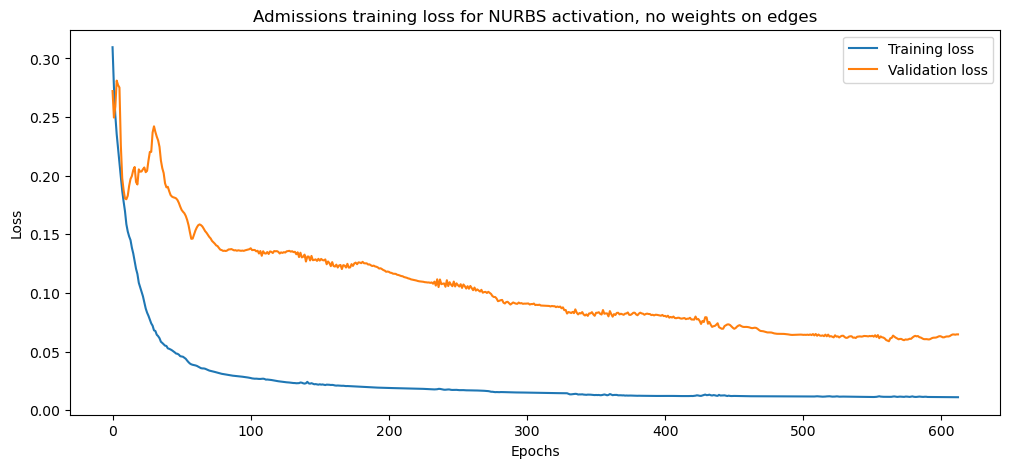

In [236]:
visualize_loss("Admissions training loss for NURBS activation, no weights on edges", train_losses, val_losses)

### Evaluate

Mean Absolute Error (MAE): 0.1827
Mean Squared Error (MSE): 0.0616
R² Score: -2.0136


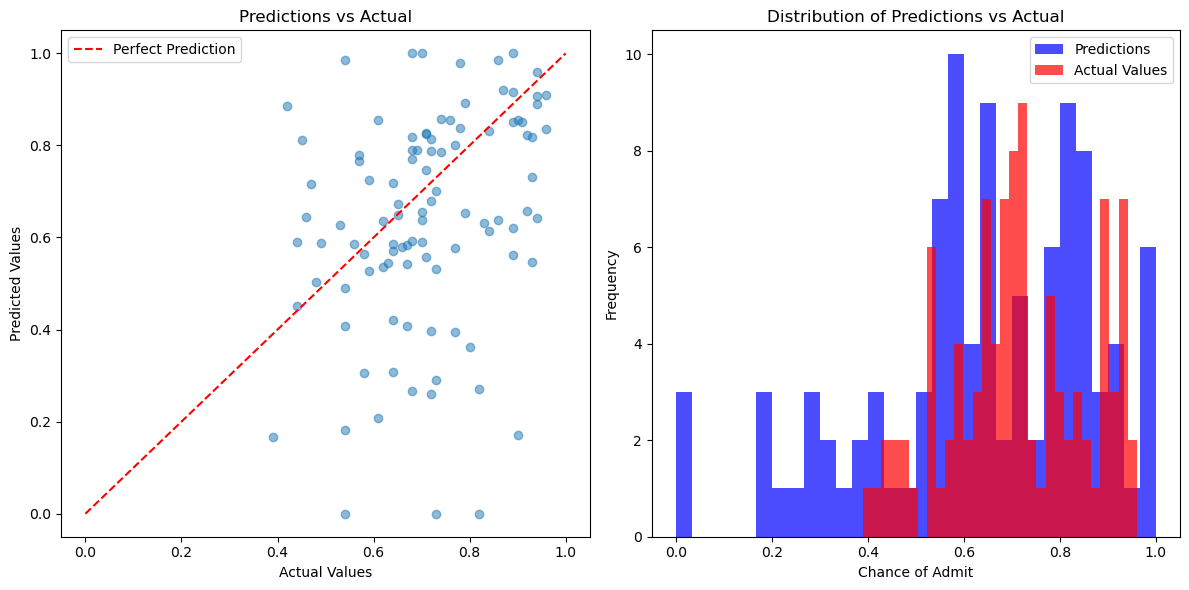

In [237]:
mae, mse, r2 = evaluate_model(stripped_nurbs_model2, X_test_tensor, y_test_tensor)

In [238]:
new_row = pd.DataFrame([{
    'model_type': 'NURBS - edge weights (2)',
    'train_time': exec_time,
    'test_mse': mse,
    'test_mae': mae,
    'test_r2': r2,
    'epochs': len(val_losses)
}])

edge_weight_summary = pd.concat([edge_weight_summary, new_row], ignore_index=True)

In [239]:
summary(stripped_nurbs_model2, input_size=X_train_tensor.shape)

Layer (type:depth-idx)                   Output Shape              Param #
StrippedTinyNURBSNN2                     [360, 1]                  --
├─Linear: 1-1                            [360, 16]                 (128)
├─NURBSActivation: 1-2                   [360, 16]                 180
├─Linear: 1-3                            [360, 8]                  (136)
├─NURBSActivation: 1-4                   [360, 8]                  180
├─Linear: 1-5                            [360, 1]                  (9)
├─Sigmoid: 1-6                           [360, 1]                  --
Total params: 633
Trainable params: 360
Non-trainable params: 273
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 0.00
Estimated Total Size (MB): 0.15

In [240]:
edge_weight_summary

,model_type,train_time,test_mse,test_mae,test_r2,epochs
0,NURBS + edge weights,10.150926,0.023864,0.127380,-0.166949,153
1,NURBS - edge weights,50.252618,0.032970,0.137552,-0.612228,230
2,NURBS - edge weights (2),110.829940,0.061628,0.182682,-2.013582,613


### <span style="color: green;">Conclusions</span>
- Regardless of the usage of edge weights, similar parameter numbers lead to similar training outcomes in final test MSE and MAE
- The architectures above provide dissatisfactory results
  - Negative R2 values indicate that the models are worse than a dummy model that always predicts the sample mean
  - Experiments with larger networks and/or different regression problems may be beneficial
- The loss graphs of the with weights vs no weights cases are very different
  - NURBS activations without learnable edge weights lead to an oscillation of not only validation, but also train loss. This might suggest that classic backpropagation (that in itself does not guarantee an improvement epoch by epoch) struggles more in providing a clear decrease in loss in the case of learnable activation functions (linearities are easier to backpropagate for than nonlinearities).
- Training times for the no weights models are exceptionally high both when multiple layers are introduced and when the control point numbers are increased for the NURBS layers. This - at least partially - is probably due to the higher number of epochs within which the early stop criteria is not met, so these versions simply train for more epochs, therefore longer. Of course, the backpropagation and forward calculations are also more complex for NURBS curve parameters than for linear parameters. Evidently, this takes more time, so the NURBS operations should be optimised in the future.

## Remains to be seen

* Do we need weights on edges if we have learnable activation functions?
    * For now, weights are turned off, later, we will see.
* Should knots be uniformly distributed or something else?
* How to initialize activation curve parameters?
    * For now, torch.randn is used in most cases, so there is random sampling from a normal distribution
    * For NURBS, B-spline type initialization seems to yield the best results (random points, uniformly 1 weights)
* Performance compared to ReLU (for same number of params)
* Performance in a more complex task e.g. image classification after CNN and flattening